In [2]:
import pyspark as ps
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

In [4]:
spark = (ps.sql.SparkSession
         .builder
         .master('local[4]')
         .appName('crime_data')
         .getOrCreate()
        )
sc = spark.sparkContext

In [6]:
spark_arrests = spark.read.csv('../data/DOJ_ArrestData1980-2019.csv',
                    header=True,
                    quote='"',
                    sep=",",
                    inferSchema=True)

In [8]:
spark_arrests.createOrReplaceTempView('arrests_tempview')

In [25]:
query = '''
select YEAR, COUNTY, SUM(VIOLENT) AS violent_crime_arrests
from arrests_tempview
where YEAR > 2002
and YEAR < 2018
GROUP BY YEAR, COUNTY
ORDER BY YEAR, COUNTY
'''

arrests_sql = spark.sql(query)
arrests_sql.show()
arrests_pd = arrests_sql.toPandas()

+----+-------------------+---------------------+
|YEAR|             COUNTY|violent_crime_arrests|
+----+-------------------+---------------------+
|2003|     Alameda County|                 4749|
|2003|      Alpine County|                    7|
|2003|      Amador County|                   92|
|2003|       Butte County|                  571|
|2003|   Calaveras County|                  166|
|2003|      Colusa County|                   83|
|2003|Contra Costa County|                 2482|
|2003|   Del Norte County|                  154|
|2003|   El Dorado County|                  614|
|2003|      Fresno County|                 4939|
|2003|       Glenn County|                  113|
|2003|    Humboldt County|                  534|
|2003|    Imperial County|                  640|
|2003|        Inyo County|                   61|
|2003|        Kern County|                 3746|
|2003|       Kings County|                  677|
|2003|        Lake County|                  319|
|2003|      Lassen C

In [41]:
arrests_pd.head(5)

,YEAR,COUNTY,violent_crime_arrests
0,2003,Alameda County,4749
1,2003,Alpine County,7
2,2003,Amador County,92
3,2003,Butte County,571
4,2003,Calaveras County,166


In [73]:
spark_population = spark.read.csv('../data/population_by_county_2003_to_2017.csv',
                    header=True,
                    quote='"',
                    sep=",",
                    inferSchema=True)

In [74]:
spark_population.createOrReplaceTempView('population_tempview')

In [75]:
query = '''
select `Year`, `County`, `Population`
from population_tempview
WHERE `County` != 'None'
'''

population_sql = spark.sql(query)
population_sql.show()
population_pd = population_sql.toPandas()

+----+------------+----------+
|Year|      County|Population|
+----+------------+----------+
|2003|     Alameda|   1467892|
|2003|      Alpine|      1248|
|2003|      Amador|     36656|
|2003|       Butte|    209389|
|2003|   Calaveras|     42651|
|2003|      Colusa|     19538|
|2003|Contra Costa|    984256|
|2003|   Del Norte|     27744|
|2003|   El Dorado|    166195|
|2003|      Fresno|    837256|
|2003|       Glenn|     26974|
|2003|    Humboldt|    129468|
|2003|    Imperial|    149041|
|2003|        Inyo|     18461|
|2003|        Kern|    707111|
|2003|       Kings|    136710|
|2003|        Lake|     61492|
|2003|      Lassen|     33828|
|2003| Los Angeles|   9756914|
|2003|      Madera|    130641|
+----+------------+----------+
only showing top 20 rows



In [76]:
population_pd

,Year,County,Population
0,2003,Alameda,1467892
1,2003,Alpine,1248
2,2003,Amador,36656
3,2003,Butte,209389
4,2003,Calaveras,42651
...,...,...,...
865,2017,Tulare,470716
866,2017,Tuolumne,54725
867,2017,Ventura,855910
868,2017,Yolo,218673


In [85]:
arrests_per_capita_pd = arrests_pd.join(population_pd)
arrests_per_capita_pd['COUNTY'] = arrests_per_capita_pd['County']
arrests_per_capita_pd.drop('Year', axis=1, inplace=True)
arrests_per_capita_pd.drop('County', axis=1, inplace=True)
arrests_per_capita_pd['arrests_per_capita'] = arrests_per_capita_pd['violent_crime_arrests'] / arrests_per_capita_pd['Population']
arrests_per_capita_pd.rename(columns = {'YEAR': 'Year', 'COUNTY': 'County', 'violent_crime_arrests': 'Violent Crime Arrests', 'arrests_per_capita': 'Arrests Per Capita', 'Population': 'Estimated Population'}, inplace=True)
arrests_per_capita_pd.head(5)

,Year,County,Violent Crime Arrests,Estimated Population,Arrests Per Capita
0,2003,Alameda,4749,1467892,0.003235
1,2003,Alpine,7,1248,0.005609
2,2003,Amador,92,36656,0.002510
3,2003,Butte,571,209389,0.002727
4,2003,Calaveras,166,42651,0.003892


In [87]:
arrests_dict = {}
for county in arrests_per_capita_pd['County'].unique():
    arrests_dict[county] = list(arrests_per_capita_pd[arrests_per_capita_pd.County==county]['Arrests Per Capita'].values)

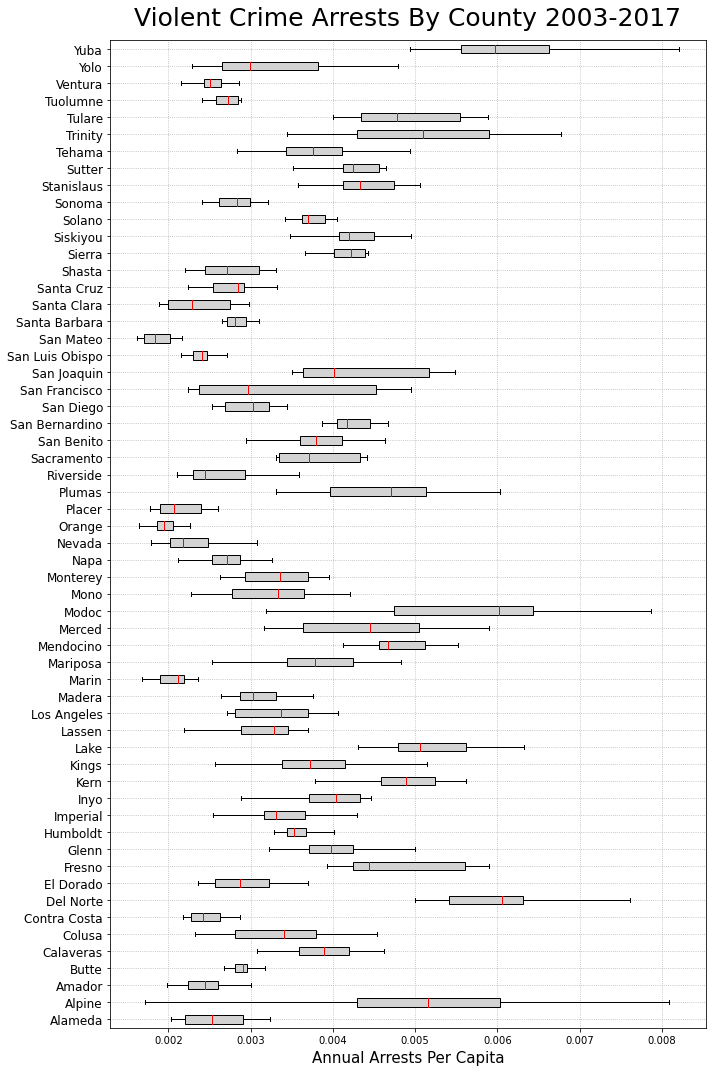

In [90]:
fig, ax = plt.subplots(figsize=(10, 15))
ax.boxplot(arrests_dict.values(), vert=False, showfliers=False, patch_artist=True,
            boxprops=dict(facecolor='lightgrey', color='black'),
            capprops=dict(color='black'),
            whiskerprops=dict(color='black'),
            flierprops=dict(color='red', markeredgecolor='red'),
            medianprops=dict(color='red'))

ax.set_yticklabels(arrests_dict.keys(), fontsize=12)
ax.set_xlabel('Annual Arrests Per Capita', fontsize=15, labelpad=5)
ax.set_title('Violent Crime Arrests By County 2003-2017', fontsize=25, pad=15)
ax.grid(linestyle=':')
fig.tight_layout()
#plt.savefig('../images/arrests box plot')